# Training pipeline using Albumentation.
### Training pipeline refactored and various Albumentation augmentation are used.

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer
from detectron2.checkpoint import DetectionCheckpointer

# Register the dataset

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "./train.json", ".")
register_coco_instances("my_dataset_val", {}, "./test.json", ".")

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils

In [7]:
from detectron2.data import build_detection_test_loader, build_detection_train_loader, DatasetMapper


class AlbumentationsMapper(DatasetMapper):
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        self.is_train = is_train
        
        self.transform = A.Compose([
            A.OneOf([
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.Transpose(p=0.5)
            ], p=0.7),
            A.OneOf([
                A.RandomBrightnessContrast(p=0.5, brightness_limit=0.4, contrast_limit=0.4, brightness_by_max=False),
                A.CLAHE(p=0.5),
            ], p=0.7),
            A.HueSaturationValue(p=0.5)
        ],
        bbox_params=A.BboxParams(format='coco', label_fields=["category_ids"]),
        p=0.65
        )
      
        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")
        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(
            image=image, 
            bboxes=bboxes, 
            category_ids=category_id
        )
        
        image = transformed["image"]
        annos = []
        
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
            
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.
        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = instances
        return dataset_dict

# visualize training data

[12/18 15:49:55 d2.data.datasets.coco]: Loaded 392 images in COCO format from ./train.json


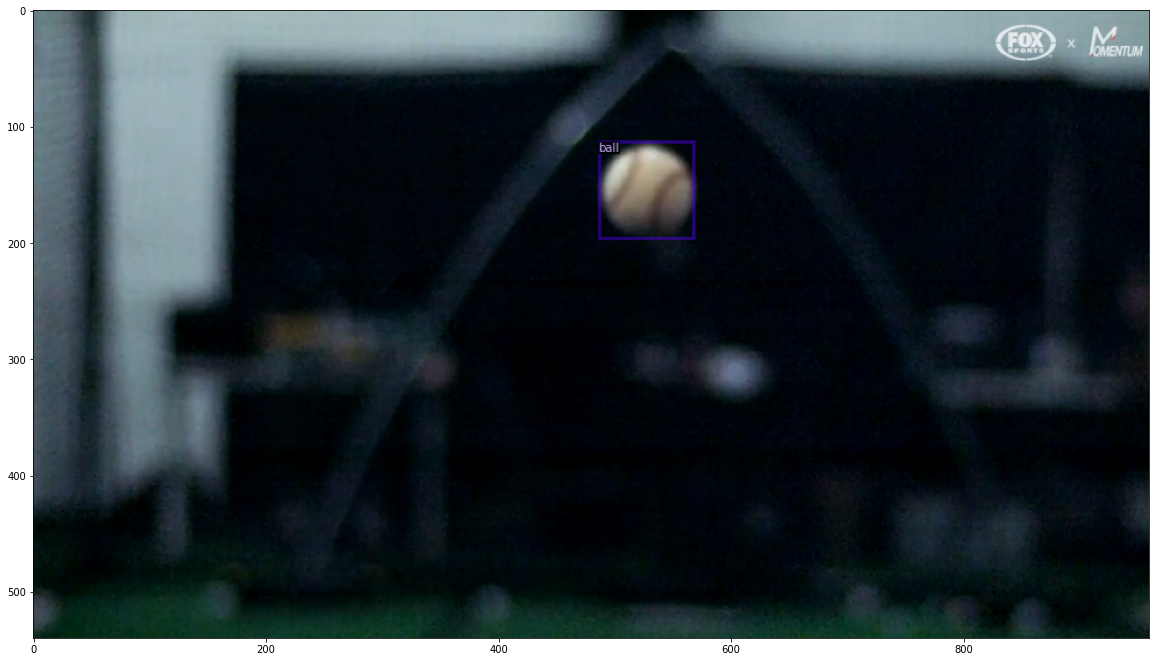

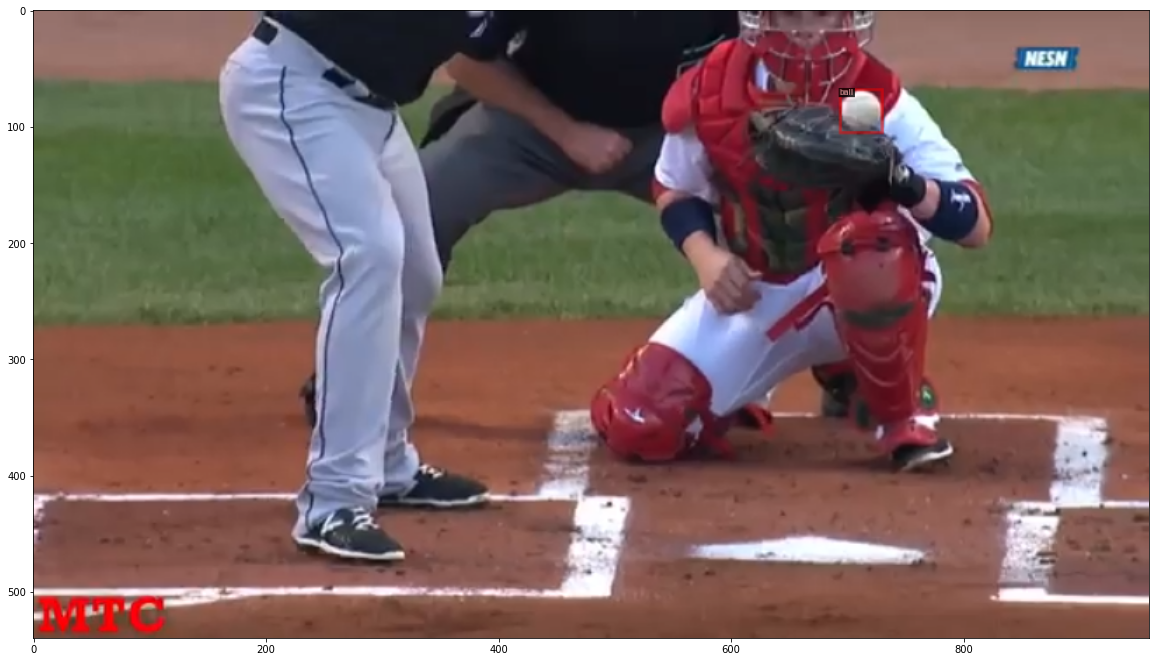

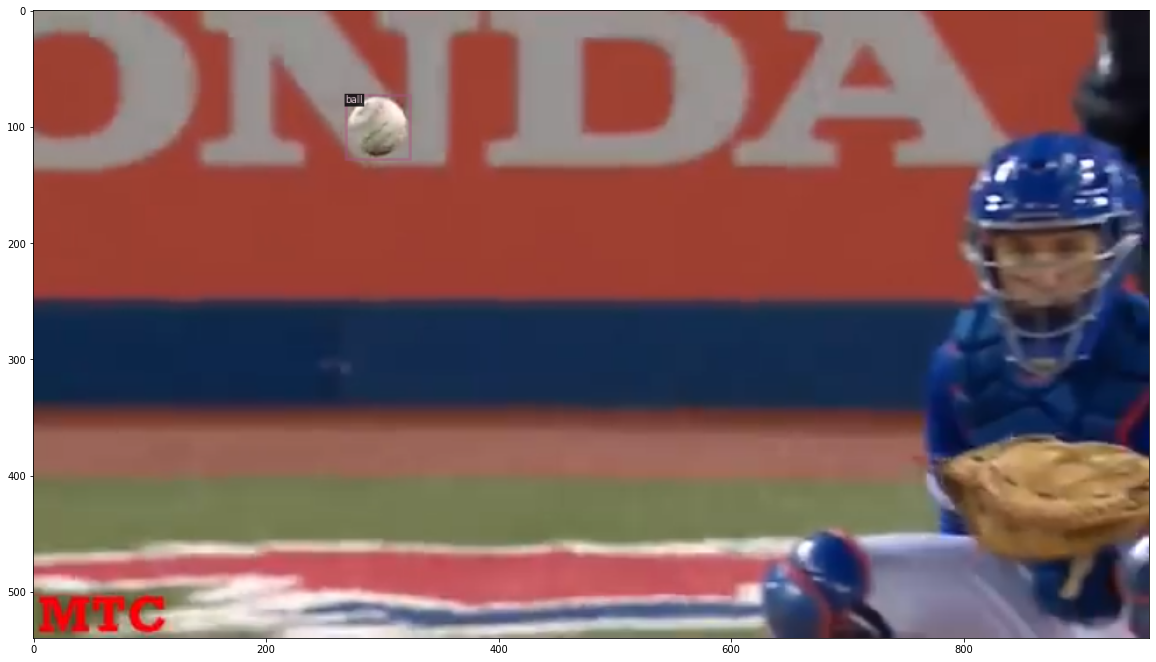

In [5]:

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img, metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())
    plt.show()

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    

## Results on accuracy is not that good

In [6]:
from detectron2.config.config import CfgNode as CN
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 300
cfg.SOLVER.MAX_ITER = 8000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = [] # (1000, 1500)
# cfg.SOLVER.GAMMA = 0.05
cfg.OUTPUT_DIR = 'rapsodo'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # your number of classes + 1
cfg.TEST.EVAL_PERIOD = 100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/18 15:52:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

2021-12-18 15:52:10.899233: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model p

[12/18 15:52:11 d2.engine.train_loop]: Starting training from iteration 0


/home/tvc/repos/CricketVideoAudioAnalysis/env/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/tvc/repos/CricketVideoAudioAnalysis/env/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/18 15:52:32 d2.utils.events]:  eta: 1:30:53  iter: 19  total_loss: 1.323  loss_cls: 0.6568  loss_box_reg: 0.6691  loss_rpn_cls: 0.008192  loss_rpn_loc: 0.002669  time: 0.9876  data_time: 0.0296  lr: 6.427e-05  max_mem: 21365M
[12/18 15:52:49 d2.utils.events]:  eta: 1:09:25  iter: 39  total_loss: 0.9328  loss_cls: 0.4299  loss_box_reg: 0.443  loss_rpn_cls: 0.01209  loss_rpn_loc: 0.002722  time: 0.8983  data_time: 0.0104  lr: 0.00013087  max_mem: 21365M
[12/18 15:53:06 d2.utils.events]:  eta: 1:09:18  iter: 59  total_loss: 0.8422  loss_cls: 0.2473  loss_box_reg: 0.6476  loss_rpn_cls: 0.009106  loss_rpn_loc: 0.002792  time: 0.8832  data_time: 0.0110  lr: 0.00019747  max_mem: 21365M
[12/18 15:53:24 d2.utils.events]:  eta: 1:09:05  iter: 79  total_loss: 0.7517  loss_cls: 0.1429  loss_box_reg: 0.5928  loss_rpn_cls: 0.009445  loss_rpn_loc: 0.002145  time: 0.8915  data_time: 0.0106  lr: 0.00026407  max_mem: 21365M
[AlbumentationsMapper] Augmentations used in inference: Compose([
  OneOf([


KeyboardInterrupt: 

# Test the Trained Model

In [ ]:
from detectron2.config.config import CfgNode as CN
from detectron2.config import get_cfg
# from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
path = '/mnt/disk1/users/masoud/models/ball_detection/2021-11-08'
cfg.MODEL.WEIGHTS = os.path.join(path, "model_0004999.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model


from detectron2.utils.visualizer import ColorMode
import glob
lst = []

predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")
test_images =  glob.glob('dataset/test/*')

for d in test_images:    
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    lst.append(v)
    plt.imshow(v.get_image())
    plt.show()